In [29]:
# This code evaluates a policy for a sequence of correlated
# trials where the observer can choose to make an observation
# at some cost, or forgo the obseration and make an immediate 
# decision based on the already accumulated evidence. 

# The second part can use the evaluation to find the optimal 
# policy in a finite sequence of trials. 


import numpy as np
import math 
from matplotlib import pyplot as plt
import seaborn as sns

#Define the number of trials and belief states.
trials = 5

#range of belief space and number of states
divisions = 10
max_range = 5
min_range = -5

#Define tolerance
theta = 0.0000001

#transition probability
alpha = 0

#probability of getting a positive signal when environment is up.
#Should be greater than 0.5
pr = 0.7

#log likelihood increment after making an observation. Could be positive or negative.
Delta = math.log(pr/(1-pr))

#cost of observation
cost = 0.02

#transtition probability
up = 0.4


states = np.arange(min_range,max_range+0.01,(max_range-min_range)/divisions)


num_states = len(states)
initial_action = np.ones([num_states,trials])

#Function to find the 
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx,array[idx]

def reward_probability(belief):
    p = math.exp(belief)/(1+math.exp(belief))
    return p

def transition_probability(belief,sign):
    transition = (pr+(1-pr)*math.exp(-belief))/(1+math.exp(-belief))
    if sign == 1:
        return transition
    elif sign == -1:
        return 1-transition
    else:
        print("Illegal call")
    
def new_state(belief,sign):
    if sign == 1:
        new_belief = math.log((alpha+(1-alpha)*math.exp(belief+Delta))/(alpha*math.exp(belief+Delta)+(1-alpha)))
        print(new_belief)
        return find_nearest(states,new_belief)
    elif sign == -1:
        new_belief = math.log((alpha+(1-alpha)*math.exp(belief-Delta))/(alpha*math.exp(belief-Delta)+(1-alpha)))
        return find_nearest(states,new_belief)
    else:
        print("Illegal call")

        

-4.1527021396127966
-3.1527021396127966
-2.1527021396127966
-1.1527021396127966
-0.15270213961279652
0.8472978603872034
1.8472978603872034
2.8472978603872034
3.8472978603872034
4.8472978603872034
5.8472978603872034
-4.1527021396127966
-3.1527021396127966
-2.1527021396127966
-1.1527021396127966
-0.15270213961279652
0.8472978603872034
1.8472978603872034
2.8472978603872034
3.8472978603872034
4.8472978603872034
5.8472978603872034
-4.1527021396127966
-3.1527021396127966
-2.1527021396127966
-1.1527021396127966
-0.15270213961279652
0.8472978603872034
1.8472978603872034
2.8472978603872034
3.8472978603872034
4.8472978603872034
5.8472978603872034
-4.1527021396127966
-3.1527021396127966
-2.1527021396127966
-1.1527021396127966
-0.15270213961279652
0.8472978603872034
1.8472978603872034
2.8472978603872034
3.8472978603872034
4.8472978603872034
5.8472978603872034
-4.1527021396127966
-3.1527021396127966
-2.1527021396127966
-1.1527021396127966
-0.15270213961279652
0.8472978603872034
1.8472978603872034
2

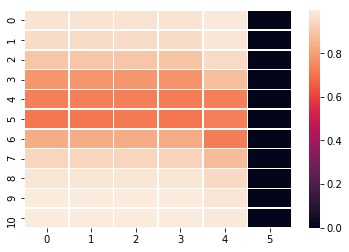

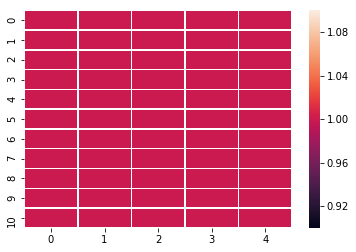

-9.152702139612796
-7.334520321430978
-5.51633850324916
-3.6981566850673415
-1.8799748668855232
-0.0617930487037048
1.7563887694781135
3.574570587659932
5.39275240584175
7.21093422402357
9.029116042205388


IndexError: index 11 is out of bounds for axis 0 with size 11

In [30]:
# This is the evaluation with no discounting and no change between trials

def evaluate(action,states):
    #Initialize values. The value of the last trial is zero, becuase that is a terminal, non-rewarding state.
    num_states = len(states)
    value = np.zeros([num_states,trials+1])
    value[num_states-1,trials-1] = 0
    
    #Implement policy evaluation
    Delta = 1
   
    n = 1
    while Delta > theta:
        Delta = 0
        for j in range(trials):
            for i in range(num_states):          
                val = value[i,j]
                if action[i,j] == 0:
                    value[i,j] = reward_probability(np.absolute(states[i])) + value[i,j+1]
                else:
                    pp = transition_probability(states[i],1)
                    pn = transition_probability(states[i],-1)
                    index_p, statep = new_state(states[i],1)
                    index_n, staten = new_state(states[i],-1)
                    value[i,j] = pp*(reward_probability(np.absolute(statep + value[index_p,j+1] - cost))) + \
                                 pn*(reward_probability(np.absolute(staten + value[index_n,j+1] - cost)))
                Delta = max(Delta,abs(val - value[i,j])) 
    return value


def maximize(action,i,j,value=None):
    if value is None:
        value = np.zeros([num_states,trials+1])
    
    current_action = action[i,j]
    
    #evaluate alternative
    if current_action == 1:
            value_alternative = reward_probability(np.absolute(states[i])) + value[i,j+1]

    else:
            pp = transition_probability(states[i],1)
            pn = transition_probability(states[i],-1)
            index_p, statep = new_state(states[i],1)
            index_n, staten = new_state(states[i],-1)
            value_alternative = pp*(reward_probability(np.absolute(statep + value[index_p,j+1] - cost))) + \
                                pn*(reward_probability(np.absolute(staten + value[index_n,j+1] - cost)))
    
    if value_alternative > value[i,j]:
            #Flip action if not the best through modding by 1
            current_action = (current_action+1)%1
    return current_action

def improve(action,value=None):
    if value is None:
        value = np.zeros([num_states,trials+1])
    
    stable = 1
    for j in range(trials-1):
            for i in range(num_states):
                old_action = action[i,j]
                action[i,j] = maximize(action,i,j,value)
                if old_action != action[i,j]:
                    stable = 0
    return action,stable


def best_action(initial_action,states=None):
    states =  np.arange(-10,10.1,20/num_states)
    
    stable = 0
    action = initial_action
    while stable == 0:
        value = evaluate(action,states)  
        action,stable = improve(action,value)
    return action, value


action = initial_action
value = evaluate(action,states)

ax = sns.heatmap(value, linewidth=0.5)
plt.show()

act = sns.heatmap(action, linewidth=0.5)
plt.show()


action,value = best_action(action,value)


ax = sns.heatmap(value, linewidth=0.5)
plt.show()

act = sns.heatmap(action, linewidth=0.5)
plt.show()



In [134]:
i = 2
j = 3

print(value[i,j])

value[i,j] = transition_probability(1)*(reward_probability(states[i+1]) + value[i+1,j+1] - cost) + \
                                 transition_probability(-1)*(reward_probability(states[i-1]) + value[i-1,j+1] - cost)
    
print(value)

0.36039186151593094
[[-0.55894288 -0.52601002 -0.4921986  -0.45436965 -0.41494231 -0.36822661
  -0.31859872 -0.25595189 -0.18794714 -0.09922643  0.        ]
 [-0.33059886 -0.30503143 -0.27414854 -0.24971137 -0.215612   -0.19319083
  -0.15327024 -0.13401988 -0.08387486 -0.06420734  0.        ]
 [ 0.31918429  0.33938501  0.34571647  0.36039186  0.34985199  0.35451323
   0.31345206  0.30034478  0.2058349   0.16596996  0.        ]
 [ 1.23006372  1.22245442  1.21773009  1.18181488  1.15116768  1.06371871
   0.98610812  0.80432005  0.64362408  0.28270026  0.        ]
 [ 2.38132822  2.36597987  2.32584212  2.27585177  2.18072743  2.06769387
   1.87200671  1.64388838  1.2584512   0.81581617  0.        ]]


In [145]:
(1+1)%1

0

In [23]:
np.absolute(-1)

1

In [17]:
len(value)

NameError: name 'value' is not defined